In [1]:
#import possibly needed modules
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import scipy.io 
import mne
import os
import sys


/Users/madwoman/opt/anaconda3/envs/neural/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [34]:
#define the path and subjects
#in_path = r"/Users/madwoman/Desktop/tpp_seeg/roi_data_67/sts/" # 分析哪个roi就输入哪个文件夹的数据
in_path = r"/Users/madwoman/Desktop/tpp_seeg/roi_data_1234_new/ipl/" # 分析哪个roi就输入哪个文件夹的数据
in_path_baseline = r"/Users/madwoman/Desktop/tpp_seeg/roi_data_baseline_new/ipl/" # 分析哪个roi就输入哪个文件夹的数据
#out_path = r"/Users/madwoman/Desktop/tpp_seeg/frqe_out/sts/" # 分析哪个roi就输入哪个文件夹的数据
#roi_name = "amy"
# subjects = [108, 116, 117, 120, 122, 135] # vmpfc  
# subjects = [119, 125, 127] # vmpfc for kids 
# subjects = [104, 108, 116, 117, 120,122] # mpfc  
# subjects = [108, 113, 117, 120, 122, 135] # ipl  
subjects = [110, 125, 127, 134] # ipl for kids
# subjects = [112, 120, 122] # sts  
# subjects = [110, 119, 125, 127] # sts for kids 
# subjects = [108, 116, 117, 120, 122] # dmpfc  
# subjects= [108, 112, 113, 116, 117, 122, 135] # amy 115 
# subjects = [110, 119, 124, 125, 127, 131] # amy for kids
# subjects = [117, 120, 122] # accg
# subjects = [109, 116, 119, 120] # striatum  删除 107  119
# subjects = [104, 113, 117, 120, 122] # acc_bn
# subjects = [104, 113] # pcc
# subjects = [104, 119, 122,123] # mcc   
# subjects = [116, 120] # nacc
# subjects = [116, 120] # dlpfc
# subjects = [113] # dacc
# subjects = [108, 112, 113, 116, 117, 120, 122, 123, 135] # insula/ai
# subjects = [110, 119, 124, 125, 127, 131, 134] # insula/ai for kids
# subjects = [125, 127] # insula/ai for kids
#epochs_name = '/biomo_epo.fif'

# subjects = [123]
#functions for gaussian filter
def gaussian_filter(data, time_span=50, fs=1000, axis=-1):

    # time_span: the length of the window (ms)
    from scipy import signal, ndimage

    winsize = time_span * fs / 1000

    # create a window(kernel) with value follow a gaussian distrubution
    window = signal.gaussian(winsize,std = int((winsize)/5) ) # Note! In matlab function 'gausswin',the parameter is α(defaut = 2.5), here is std, std = winsize/2α

    # Make the sum of the window = 1
    gusWin = window/sum(window)

    # convolve the last dimension
    data_filtered = ndimage.convolve1d(input=data, weights=gusWin, axis=axis, mode='nearest', origin=0)

    return data_filtered

In [35]:
from mne.time_frequency import tfr_morlet
#freqs=np.arange(70, 125, 5)
freqs=np.arange(50, 150, 2)
n_cycles=10
time_span = 100
ch_names = []
whole_range = [-7, 0.999]  # baseline前后 0.3s
baseline_range = [0, 0.2]


# 生成时间序列
time_range = np.arange(baseline_range[0]-baseline_range[1] + whole_range[0], whole_range[1], 0.001)
for i in range(len(subjects)):

    # 导入eegepoch数据
    ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')

    #epoch selection

    selected_tags = [tag for tag in ROI_epochs.event_id if '50' in tag and '6' in tag]
    pn_epochs = ROI_epochs[selected_tags]

    selected_tags = [tag for tag in ROI_epochs.event_id if '50' in tag and '7' in tag]
    npn_epochs = ROI_epochs[selected_tags]

    ##计算tfr: attention v.s. non-attention in punished trials
    tfr_ROI_epoch_pn = tfr_morlet(pn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)
    tfr_ROI_epoch_npn = tfr_morlet(npn_epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True, use_fft=True)

    baseline_epoches = mne.read_epochs_eeglab(in_path_baseline + str(subjects[i]) + '.set')

    selected_tags = [tag for tag in baseline_epoches.event_id if '50' in tag and '6' in tag]
    pn_epochs = baseline_epoches[selected_tags]

    selected_tags = [tag for tag in baseline_epoches.event_id if '50' in tag and '7' in tag]
    npn_epochs = baseline_epoches[selected_tags]
    ##计算tfr: attention v.s. non-attention in punished trials

    tfr_ROI_epoch_pn_base = tfr_morlet(pn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    tfr_ROI_epoch_npn_base = tfr_morlet(npn_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
   
    baseline_interval = [0.002, 0.2]
    # Crop the baseline interval from the baseline dataset
    baseline_epochs_pn = tfr_ROI_epoch_pn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    baseline_epochs_npn = tfr_ROI_epoch_npn_base.copy().crop(tmin=baseline_interval[0], tmax=baseline_interval[1])
    # Apply baseline correction to the main dataset using the cropped baseline interval
    
    # Concatenate the baseline and main TFR data along the time axis
    pn_mean_tfr = np.concatenate((baseline_epochs_pn.data, tfr_ROI_epoch_pn.data), axis=2)
    npn_mean_tfr = np.concatenate((baseline_epochs_npn.data, tfr_ROI_epoch_npn.data), axis=2)
#####
   

    info = mne.create_info(ch_names = ROI_epochs.ch_names, ch_types = 'eeg', sfreq = 1000)
    
    # 生成mne的tfr文件
    all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
    all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


    #baseline correction
    all_pn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))
    all_npn_mean_tfr.apply_baseline(mode='zlogratio', baseline=(-7.2, -7.002))
    # Get data using get_data() method
    #data_pn = epochs_pn.get_data()
    #data_npn = epochs_npn.get_data()
#####################

    # gaussian_filter
    smooth_hgb_pn_data = gaussian_filter(data=np.mean(all_pn_mean_tfr.data,axis=1), time_span=time_span, fs=ROI_epochs.info['sfreq'])
    smooth_hgb_npn_data = gaussian_filter(data=np.mean(all_npn_mean_tfr.data,axis=1), time_span=time_span, fs=ROI_epochs.info['sfreq'])
    # shape: trial, channel, time
      
    if i == 0:
        all_smooth_hgb_pn_data = smooth_hgb_pn_data
        all_smooth_hgb_npn_data = smooth_hgb_npn_data
        ch_names = np.array(ROI_epochs.ch_names)
    else:
        all_smooth_hgb_pn_data = np.vstack((all_smooth_hgb_pn_data, smooth_hgb_pn_data))
        all_smooth_hgb_npn_data = np.vstack((all_smooth_hgb_npn_data, smooth_hgb_npn_data))
        ch_names = np.hstack((ch_names, np.array(ROI_epochs.ch_names)))
  

Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_new/ipl/110.set...
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline_new/ipl/110.set...
Not setting metadata
48 matching events found


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.6s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:30: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches = mne.read_epochs_eeglab(in_path_baseline + str(subjects[i]) + '.set')


No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.8s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:58: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_new/ipl/125.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline_new/ipl/125.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:30: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches = mne.read_epochs_eeglab(in_path_baseline + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Applying baseline correction (mode: zlogratio)
Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.1s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:58: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_new/ipl/127.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline_new/ipl/127.set...


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    4.8s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:30: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches = mne.read_epochs_eeglab(in_path_baseline + str(subjects[i]) + '.set')


Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    7.5s finished


Applying baseline correction (mode: zlogratio)


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:58: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


Applying baseline correction (mode: zlogratio)
Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_1234_new/ipl/134.set...
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:16: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


Extracting parameters from /Users/madwoman/Desktop/tpp_seeg/roi_data_baseline_new/ipl/134.set...
Not setting metadata
48 matching events found


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.5s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:30: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  baseline_epoches = mne.read_epochs_eeglab(in_path_baseline + str(subjects[i]) + '.set')


No baseline correction applied
0 projection items activated
Ready.
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


Applying baseline correction (mode: zlogratio)


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s finished
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:57: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_pn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=pn_mean_tfr, times=time_range, freqs=freqs, nave=1)
/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1482584032.py:58: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  all_npn_mean_tfr = mne.time_frequency.AverageTFR(info=info, data=npn_mean_tfr, times=time_range, freqs=freqs, nave=1)


Applying baseline correction (mode: zlogratio)


In [183]:
selected_tags

['3/50/31/7/2',
 '3/50/30/7/2',
 '4/50/41/7/3',
 '1/50/10/7/1',
 '4/50/40/7/3',
 '1/50/11/7']

In [36]:
# create a new epochs info
info_fast = mne.create_info(ch_names = list(np.arange(all_smooth_hgb_pn_data.shape[0]).astype('str')), ch_types = 'eeg', sfreq = 1000)
info_slow = mne.create_info(ch_names = list(np.arange(all_smooth_hgb_npn_data.shape[0]).astype('str')), ch_types = 'eeg', sfreq = 1000)

# create a new ROI based epochs
all_smooth_hgb_pn = mne.EvokedArray(data = all_smooth_hgb_pn_data, info = info_fast, tmin=-6.8)#改成-6.8
all_smooth_hgb_npn = mne.EvokedArray(data = all_smooth_hgb_npn_data, info = info_slow, tmin=-6.8)

times = all_smooth_hgb_npn.times

all_smooth_hgb_pn_crop = all_smooth_hgb_pn
all_smooth_hgb_npn_crop = all_smooth_hgb_npn

all_smooth_hgb_pn_crop = all_smooth_hgb_pn_crop.crop(-0.8, 0.1)#看做决策前后哪一段
all_smooth_hgb_npn_crop = all_smooth_hgb_npn_crop.crop(-0.8, 0.1) # vmpfc(0, 1.1)

n_permutations = 10000

# 两种情况下相对于0的显著性
T_obs_fast, clusters_fast, cluster_p_values_fast, H0_fast  = mne.stats.permutation_cluster_1samp_test(all_smooth_hgb_pn_crop.data, 
                                                    out_type='mask',n_permutations=n_permutations, n_jobs=6, tail=0, verbose=None)

T_obs_slow, clusters_slow, cluster_p_values_slow, H0_slow  = mne.stats.permutation_cluster_1samp_test(all_smooth_hgb_npn_crop.data, 
                                                    out_type='mask',n_permutations=n_permutations, n_jobs=6, tail=0, verbose=None)

# 两者之间的显著性
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([all_smooth_hgb_pn_crop.data, all_smooth_hgb_npn_crop.data],
                                                                out_type='mask', n_permutations=n_permutations, n_jobs=6,tail=0
                                                                ,verbose=None) #, stat_fun=scipy.stats.ttest_ind())

# all_smooth_hgb_fast = all_smooth_hgb_fast.crop(-0.1, 1.1)
# all_smooth_hgb_slow = all_smooth_hgb_slow.crop(-0.1, 1.1)

Using a threshold of 1.982383
stat_fun(H1): min=-6.401331003340133 max=0.5715874980779462
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.982383
stat_fun(H1): min=-4.267649430256818 max=2.83775496680116
Running initial clustering …
Found 7 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 3.885280
stat_fun(H1): min=3.488270959464164e-06 max=18.783442035389896
Running initial clustering …
Found 4 clusters


/var/folders/9v/hrxf86p91h31ptwdds0f77qw0000gn/T/ipykernel_18466/1177071300.py:27: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([all_smooth_hgb_pn_crop.data, all_smooth_hgb_npn_crop.data],


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

## Adults

(array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2]),
 [Text(-1.0, 0, '−1.0'),
  Text(-0.8, 0, '−0.8'),
  Text(-0.6, 0, '−0.6'),
  Text(-0.3999999999999999, 0, '−0.4'),
  Text(-0.19999999999999996, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.20000000000000018, 0, '0.2')])

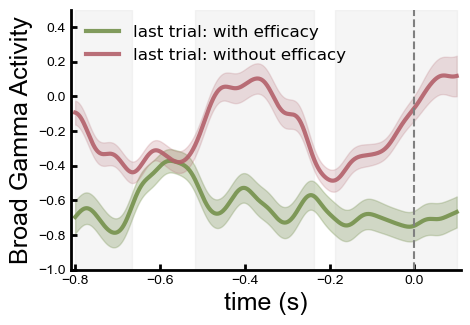

In [33]:
#line_color = ['#A4132E','#B97979']
#line_color = ['#984447','#476C9B'] #original red&blue
#line_color = ['#B3606A','#729D35']
line_color = ['#75914C', '#B3606A']
# line_color = ['#F3C939','#8CBCE5']
figsize=(6,4) 
title_size=20
legend_size=12
ticksize = 20
subplots_adjust=[0.2, 0.2, 0.85, 0.85]


import matplotlib.pyplot as plt
import numpy as np
import os

# if not os.path.exists(result_path):
# os.mkdir(result_path)    
# # plot for each ROI
# for ROI_num in range(len(permutation_cluster_result['ROI_name'])):

event_0_line_color = line_color[0]
event_1_line_color = line_color[1]

# the number of time axis
times = all_smooth_hgb_npn.times

plt.close('all')
plt.rcParams['figure.figsize'] = figsize # 设置figure_size尺寸
# plt.title('ROI: '+ roi_name, fontdict={'fontsize':title_size})

epoch_mean={}
epoch_mean[0] = np.squeeze(np.average(all_smooth_hgb_pn.data, axis=0))#就是每根电极的平均
epoch_mean[1] = np.squeeze(np.average(all_smooth_hgb_npn.data, axis=0))

plt.plot(times, epoch_mean[0], color=line_color[0], alpha=0.9, linewidth=3) # , linestyle='--')
plt.plot(times, epoch_mean[1], color=line_color[1], alpha=0.9, linewidth=3) # , linestyle='--')

# 标注哪条线是哪个event
#legend_font = {'family': fontproperties}
plt.legend(['last trial: with efficacy', 'last trial: without efficacy'], fontsize=legend_size, frameon=False, loc='upper left') #, loc='top')

# 画0s时的分割线 
# plt.axvline(times[101], c="gray", ls = "dashed")
plt.axvline(times[800], c="gray", ls = "dashed")
#plt.plot(times, np.zeros(len(epoch_mean[0])), color="gray", linestyle="--")

# 画误差(std),现在的版本是阴影部分代表每根电极
std_event0 = np.squeeze(np.std(all_smooth_hgb_pn.data, axis=0))
std_event1 = np.squeeze(np.std(all_smooth_hgb_npn.data, axis=0))

se_event0 = std_event0/np.sqrt(all_smooth_hgb_pn.data.shape[0])
se_event1 = std_event1/np.sqrt(all_smooth_hgb_npn.data.shape[0])

plt.fill_between(times, epoch_mean[0] - se_event0, epoch_mean[0] + se_event0, color=line_color[0], alpha=0.3)
plt.fill_between(times, epoch_mean[1] - se_event1, epoch_mean[1] + se_event1, color=line_color[1], alpha=0.2)

# event 间的显著性
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        plt.axvspan(times[c.start], times[c.stop-1], color='#A4A4A4', alpha=0.1)
        #plt.plot(times[c.start : c.stop - 1],  -20e-1* np.ones(len(epoch_mean[0]))[c.start : c.stop-1], color='#872C78', alpha=0.7, linewidth=10)

#hf = plt.plot(times, T_obs, 'g')
#plt.legend((h, ), ('cluster p-value < 0.05', ))
plt.subplots_adjust(left=subplots_adjust[0], bottom=subplots_adjust[1], right=subplots_adjust[2], top=subplots_adjust[3], hspace=0.1,wspace=0.1)

plt.xlim([times[0]-0.01, times[-1]+0.01])
plt.ylim(-10e-1, 0.05e+1)

plt.yticks(size=ticksize)
plt.xticks(size=ticksize)

spines_width = 2
ax=plt.gca()
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['left'].set_linewidth(spines_width)
ax.spines['bottom'].set_linewidth(spines_width)
# sns.despine()

# 坐标轴刻度粗细,朝内
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# plt.set_ylabel("Escape Accuracy", size=ticksize, fontproperties='Arial')

labelsize=18
plt.xlabel("time (s)", fontsize=labelsize, fontproperties='Arial')
plt.ylabel("Broad Gamma Activity", size=labelsize, fontproperties='Arial')
# plt.ylabel("Broad Gamma Activity", size=labelsize, fontproperties='Arial')
# plt.ylabel("Beta Activity", size=labelsize, fontproperties='Arial')
# 坐标的粗细
ticksize = 18
plt.yticks(size=ticksize, fontproperties='Arial')
plt.xticks(size=ticksize, fontproperties='Arial')


## Children

(array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2]),
 [Text(-1.0, 0, '−1.0'),
  Text(-0.8, 0, '−0.8'),
  Text(-0.6, 0, '−0.6'),
  Text(-0.3999999999999999, 0, '−0.4'),
  Text(-0.19999999999999996, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.20000000000000018, 0, '0.2')])

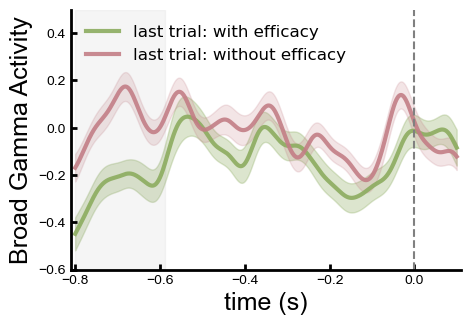

In [41]:
#line_color = ['#A4132E','#B97979']
#line_color = ['#984447','#476C9B'] #original red&blue
# line_color = ['#F1B84D','#449AD0']
line_color = ['#8cac5f','#c37e86']
figsize=(6, 4) 
title_size=20
legend_size=12
ticksize = 20
subplots_adjust=[0.2, 0.2, 0.85, 0.85]


import matplotlib.pyplot as plt
import numpy as np
import os

# if not os.path.exists(result_path):
# os.mkdir(result_path)    
# # plot for each ROI
# for ROI_num in range(len(permutation_cluster_result['ROI_name'])):

event_0_line_color = line_color[0]
event_1_line_color = line_color[1]

# the number of time axis
times = all_smooth_hgb_npn.times

plt.close('all')
plt.rcParams['figure.figsize'] = figsize # 设置figure_size尺寸
# plt.title('ROI: '+ roi_name, fontdict={'fontsize':title_size})

epoch_mean={}
epoch_mean[0] = np.squeeze(np.average(all_smooth_hgb_pn.data, axis=0))#就是每根电极的平均
epoch_mean[1] = np.squeeze(np.average(all_smooth_hgb_npn.data, axis=0))

plt.plot(times, epoch_mean[0], color=line_color[0], alpha=0.9, linewidth=3) # , linestyle='--')
plt.plot(times, epoch_mean[1], color=line_color[1], alpha=0.9, linewidth=3) # , linestyle='--')

# 标注哪条线是哪个event
#legend_font = {'family': fontproperties}
plt.legend(['last trial: with efficacy', 'last trial: without efficacy'], fontsize=legend_size, frameon=False, loc='upper left') #, loc='top')

# 画0s时的分割线 
# plt.axvline(times[101], c="gray", ls = "dashed")
plt.axvline(times[800], c="gray", ls = "dashed")
#plt.plot(times, np.zeros(len(epoch_mean[0])), color="gray", linestyle="--")

# 画误差(std),现在的版本是阴影部分代表每根电极
std_event0 = np.squeeze(np.std(all_smooth_hgb_pn.data, axis=0))
std_event1 = np.squeeze(np.std(all_smooth_hgb_npn.data, axis=0))

se_event0 = std_event0/np.sqrt(all_smooth_hgb_pn.data.shape[0])
se_event1 = std_event1/np.sqrt(all_smooth_hgb_npn.data.shape[0])

plt.fill_between(times, epoch_mean[0] - se_event0, epoch_mean[0] + se_event0, color=line_color[0], alpha=0.3)
plt.fill_between(times, epoch_mean[1] - se_event1, epoch_mean[1] + se_event1, color=line_color[1], alpha=0.2)

# event 间的显著性
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        plt.axvspan(times[c.start], times[c.stop-1], color='#A4A4A4', alpha=0.1)
        #plt.plot(times[c.start : c.stop - 1],  -20e-1* np.ones(len(epoch_mean[0]))[c.start : c.stop-1], color='#872C78', alpha=0.7, linewidth=10)

#hf = plt.plot(times, T_obs, 'g')
#plt.legend((h, ), ('cluster p-value < 0.05', ))
plt.subplots_adjust(left=subplots_adjust[0], bottom=subplots_adjust[1], right=subplots_adjust[2], top=subplots_adjust[3], hspace=0.1,wspace=0.1)

plt.xlim([times[0]-0.01, times[-1]+0.01])
plt.ylim(-6e-1, 0.05e+1)

plt.yticks(size=ticksize)
plt.xticks(size=ticksize)

spines_width = 2
ax=plt.gca()
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['left'].set_linewidth(spines_width)
ax.spines['bottom'].set_linewidth(spines_width)
# sns.despine()

# 坐标轴刻度粗细,朝内
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# plt.set_ylabel("Escape Accuracy", size=ticksize, fontproperties='Arial')

labelsize=18
plt.xlabel("time (s)", fontsize=labelsize, fontproperties='Arial')
plt.ylabel("Broad Gamma Activity", size=labelsize, fontproperties='Arial')
#plt.ylabel("Broad Gamma Activity", size=labelsize, fontproperties='Arial')
# plt.ylabel("Beta Activity", size=labelsize, fontproperties='Arial')
# 坐标的粗细
ticksize = 18
plt.yticks(size=ticksize, fontproperties='Arial')
plt.xticks(size=ticksize, fontproperties='Arial')
